## Loading Data and functions

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt
import datetime
database = 'database.sqlite'

conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)

match = pd.read_sql("""SELECT *
                        FROM Match;""", conn)
player_attributes = pd.read_sql("""SELECT *
                        FROM Player_Attributes;""", conn)

team_attributes = pd.read_sql("""SELECT *
                        FROM Team_Attributes;""", conn)

player = pd.read_sql("""SELECT *
                        FROM Player;""", conn)

In [3]:
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [4]:

home_cols = match.columns[55:66].tolist()
id_team = match.columns[7]
home_cols.append(id_team)
away_cols = match.columns[66:72].tolist()
id_team = match.columns[8]
away_cols.append(id_team)

def transform_unique(data,cols,t_id):
    filtered = data[cols].set_index(t_id)
    filtered = filtered.stack().reset_index().rename(columns={0:'player_id',t_id: 'team_id'})
    filtered = filtered.drop(columns = ['level_1'])
    filtered = filtered.groupby(['team_id','player_id']).size().reset_index().rename(columns={0:'count'})
    return filtered
transform_unique(match, home_cols,'home_team_api_id' )


def tranform_whole_date(data, home_cols, away_cols, t_away_id, t_home_id ):
    rv = pd.DataFrame(columns=['league_id','season','team_id','player_id','loose+tie','wins'])
    for i in data['league_id'].unique():
        for j in data['season'].unique():
               
            data_filtered_sl = data[(data['league_id'] == i ) &( data['season'] == j)] 
            
            filter_wins_away = data_filtered_sl[(data_filtered_sl.away_team_goal > data_filtered_sl.home_team_goal)]
            filter_wins_home = data_filtered_sl[(data_filtered_sl.away_team_goal < data_filtered_sl.home_team_goal)]
            filter_loose_away = data_filtered_sl[(data_filtered_sl.away_team_goal <= data_filtered_sl.home_team_goal)]
            filter_loose_home = data_filtered_sl[(data_filtered_sl.away_team_goal >= data_filtered_sl.home_team_goal)]
            
            filtered_home_w = transform_unique(filter_wins_home, home_cols,t_home_id ).rename(columns={'count':'wins'})
            filtered_away_w = transform_unique(filter_wins_away, away_cols,t_away_id ).rename(columns={'count':'wins'})
            filtered_home_l = transform_unique(filter_loose_home, home_cols,t_home_id ).rename(columns={'count':'loose+tie'})
            filtered_away_l = transform_unique(filter_loose_away, away_cols,t_away_id ).rename(columns={'count':'loose+tie'})     
            
            unique_team_player = pd.concat([filtered_away_w,filtered_away_l,filtered_home_w,filtered_home_l])
            unique_team_player = unique_team_player.groupby(['team_id','player_id']).sum().reset_index()

            temp  =  unique_team_player
            temp['league_id'] = i
            temp['season'] = j
            rv=rv.append(temp)
    return rv
            
def get_number_matches(data,t_away_id, t_home_id):
    number_matches_away = data.groupby(['league_id','season',t_away_id]).size().reset_index().rename(columns={0:'total_played_games',t_away_id:'team_id'})
    number_matches_home = data.groupby(['league_id','season',t_home_id]).size().reset_index().rename(columns={0:'total_played_games',t_home_id:'team_id'})
    number_maches = pd.concat([number_matches_away,number_matches_home])
    return number_maches.groupby(['league_id','season','team_id']).sum().reset_index()     

def to_season(data, t_id,player=False):
    if player:
        label = 'player_id'
    else:
        label = 'team_id'
    wk_data = data.copy()
    wk_data['date']=pd.to_datetime(wk_data['date'])
    wk_data['year'] = wk_data.date.dt.year*100 + wk_data.date.dt.month
    wk_data['season']=np.where( wk_data.year>201506,'2015/2016',None)
    wk_data['season']=np.where( (wk_data.year<=201506) & (wk_data.year>201406) ,'2014/2015',wk_data['season'])
    wk_data['season']=np.where( (wk_data.year<=201406) & (wk_data.year>201306) ,'2013/2014',wk_data['season'])
    wk_data['season']=np.where( (wk_data.year<=201306) & (wk_data.year>201206) ,'2012/2013',wk_data['season'])
    wk_data['season']=np.where( (wk_data.year<=201206) & (wk_data.year>201106) ,'2011/2012',wk_data['season'])
    wk_data['season']=np.where( (wk_data.year<=201106) & (wk_data.year>201006) ,'2010/2011',wk_data['season'])
    wk_data['season']=np.where( (wk_data.year<=201006) & (wk_data.year>200906) ,'2009/2010',wk_data['season'])
    wk_data['season']=np.where( (wk_data.year<=200906) & (wk_data.year>200806) ,'2008/2009',wk_data['season'])
    wk_data['season']=np.where( (wk_data.year<=200806) & (wk_data.year>200706) ,'2007/2008',wk_data['season'])
    wk_data['season']=np.where( (wk_data.year<=200706) & (wk_data.year>200606) ,'2006/2007',wk_data['season'])
    wk_data_season = wk_data.groupby([t_id,'season']).mean().reset_index()
    wk_data_season = wk_data_season.drop(columns = ['id','year']).rename(columns={t_id : label})
    return wk_data_season

            
        

In [5]:
import numpy as np

class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

## Creating Datasets

In [6]:
transform_data = tranform_whole_date(match, home_cols, away_cols, 'away_team_api_id', 'home_team_api_id' )
transform_data = transform_data.fillna(0)
number_matches = get_number_matches(match,'away_team_api_id', 'home_team_api_id')
transform_data = transform_data.merge(number_matches)
transform_data['rank'] = transform_data.wins/(transform_data.total_played_games) 

player_attributes_season = to_season(player_attributes,'player_api_id',True)
team_attributes_season = to_season(team_attributes,'team_api_id')

final_data = transform_data.merge(player_attributes_season)
final_data = final_data.merge(team_attributes_season)
#player.rename(columns = {'player_api_id':'player_id'})
final_data = final_data.merge(player)

/Users/juanvila1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/juanvila1/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/Users/juanvila1/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1089: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [7]:
final_data

,league_id,loose+tie,player_id,season,team_id,wins,total_played_games,rank,player_fifa_api_id,overall_rating,...,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,id,player_api_id,player_name,birthday,height,weight
0,1,13.0,6800.0,2009/2010,8203,11.0,28,0.392857,136110.0,65.000000,...,50.0,60.0,70.0,60.0,5148,6800,Jonas Ivens,1984-10-14 00:00:00,187.96,190
1,13274,16.0,6800.0,2010/2011,8674,17.0,34,0.500000,136110.0,67.500000,...,62.0,43.0,44.0,49.0,5148,6800,Jonas Ivens,1984-10-14 00:00:00,187.96,190
2,13274,14.0,6800.0,2011/2012,8674,5.0,34,0.147059,136110.0,68.000000,...,42.0,49.0,47.0,53.0,5148,6800,Jonas Ivens,1984-10-14 00:00:00,187.96,190
3,13274,5.0,6800.0,2013/2014,10219,0.0,34,0.000000,136110.0,65.000000,...,55.0,29.0,28.0,36.0,5148,6800,Jonas Ivens,1984-10-14 00:00:00,187.96,190
4,1,6.0,17276.0,2009/2010,8203,7.0,28,0.250000,155681.0,67.000000,...,50.0,60.0,70.0,60.0,548,17276,Aloys Nong,1983-10-16 00:00:00,180.34,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24790,24558,9.0,289732.0,2015/2016,10191,5.0,36,0.138889,206431.0,67.000000,...,66.0,47.0,45.0,53.0,9186,289732,Roman Buess,1992-09-21 00:00:00,182.88,168
24791,24558,6.0,462944.0,2015/2016,10191,2.0,36,0.055556,216779.0,57.500000,...,66.0,47.0,45.0,53.0,3478,462944,Francesco Ruberto,1993-03-19 00:00:00,182.88,165
24792,24558,16.0,563066.0,2015/2016,10191,8.0,36,0.222222,228999.0,53.333333,...,66.0,47.0,45.0,53.0,10106,563066,Sven Joss,1994-07-18 00:00:00,177.80,150
24793,24558,0.0,659742.0,2015/2016,10191,1.0,36,0.027778,229900.0,49.600000,...,66.0,47.0,45.0,53.0,9473,659742,Sandro Lauper,1996-10-25 00:00:00,185.42,154


### Second Ranking

In [8]:
final_data2 = final_data[['player_id','team_id','rank']].groupby(['player_id','team_id']).count().reset_index()
mean_team_att = team_attributes_season.groupby('team_id').mean().reset_index()
mean_player_att = player_attributes_season.groupby('player_id').mean().reset_index()
final_data2  = final_data2.merge(mean_player_att, on='player_id')
final_data2  = final_data2.merge(mean_team_att, on='team_id')

final_data2 = final_data2.merge(player)

In [9]:
final_data2

,player_id,team_id,rank,player_fifa_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,...,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,id,player_api_id,player_name,birthday,height,weight
0,2625.0,2183,1,148544.0,60.571429,62.000000,49.571429,47.500000,46.500000,59.000000,...,59.25,49.5,40.75,51.5,8372,2625,"Patryk Rachwal,18",1981-01-27 00:00:00,175.26,154
1,2625.0,8021,1,148544.0,60.571429,62.000000,49.571429,47.500000,46.500000,59.000000,...,55.20,58.2,52.00,55.6,8372,2625,"Patryk Rachwal,18",1981-01-27 00:00:00,175.26,154
2,10933.0,2183,1,203543.0,66.222222,66.222222,65.222222,65.055556,61.166667,72.805556,...,59.25,49.5,40.75,51.5,9033,10933,Robert Jez,1981-07-10 00:00:00,177.80,159
3,10933.0,8021,1,203543.0,66.222222,66.222222,65.222222,65.055556,61.166667,72.805556,...,55.20,58.2,52.00,55.6,9033,10933,Robert Jez,1981-07-10 00:00:00,177.80,159
4,13329.0,2183,1,148480.0,58.381481,60.825926,53.222222,43.333333,62.962963,50.688889,...,59.25,49.5,40.75,51.5,1286,13329,Blazej Telichowski,1984-06-06 00:00:00,187.96,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14853,570360.0,8613,1,223829.0,66.000000,70.916667,67.333333,34.333333,43.333333,60.333333,...,53.00,32.0,62.00,54.0,618,570360,Anderson Correia,1991-05-06 00:00:00,177.80,150
14854,667952.0,8613,1,223302.0,59.000000,68.133333,46.333333,49.333333,47.333333,61.000000,...,53.00,32.0,62.00,54.0,9438,667952,Samu,1996-04-21 00:00:00,170.18,146
14855,687288.0,8613,1,229889.0,64.125000,74.125000,54.000000,64.000000,49.000000,53.000000,...,53.00,32.0,62.00,54.0,642,687288,Andre Bukia,1995-03-03 00:00:00,172.72,143
14856,687289.0,8613,1,229890.0,62.900000,69.900000,34.700000,24.000000,62.900000,45.600000,...,53.00,32.0,62.00,54.0,3009,687289,Emmanuel Hackman,1995-05-14 00:00:00,187.96,157


## OLS + Ridge

### Functions

In [53]:
def svd_ridge(y,x,lambda_r,cons=True):
    if cons:
        X = np.column_stack((x,np.ones([len(x),1])))
    else:
        X=x.copy()
    U,Sig,VT = np.linalg.svd(X)
    n,p = X.shape
    S_inv = np.zeros((p,n))
    S = np.zeros((n,p))
    for i in range(p):
        S_inv[i][i]= Sig[i]/(Sig[i]**2 + lambda_r)
    w = VT.T.dot(S_inv).dot(U.T).dot(y)
    return w


def cross_val(y,X,n):
    '''
    Description: This function create a cross validation for y set and X set, requiere that the number of cross validation
    divide in int numbers the amount of rows of the original dataset. The cross validation is implemented throught a ridge
    regression with lambda = .5. This implementation assume that y is a continous one.
    input: 
    y: y variable to predict
    x: features
    n: number of cross val sets
    output:
    average error rate
    '''
    data = np.column_stack((y,X))
    np.random.shuffle(data)
    data_cv = np.split(data,n)
    rv =[]
    for i in range(n):
        temp=data_cv.copy()
        test_set = temp.pop(i)
        y_test, x_test =  test_set[:,[0]], test_set[:,1:]
        train_set = np.concatenate(temp,axis=0)
        y_train, x_train = train_set[:,[0]], train_set[:,1:]
        w = svd_ridge(y_train,x_train,.5)
        x_test = np.column_stack((x_test,np.ones([len(x_test),1])))
        y_hat = np.dot(x_test,w)
        error_sq =  (y_hat - y_test)**2
        rv.append(np.sqrt(np.sum(error_sq)))
    rv=np.array(rv)
    
    return rv.mean()

### Data prep

In [54]:
'''
x_cols= ['crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control']
'''


x_cols= ['crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'buildUpPlaySpeed',
       'buildUpPlayDribbling', 'buildUpPlayPassing', 'chanceCreationPassing',
       'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure',
       'defenceAggression', 'defenceTeamWidth','height', 'weight','year_b']
#Notas 0 
data_r1 = final_data.copy()
data_r2 = final_data2.copy()
data_r1.dropna(inplace=True)
data_r2.dropna(inplace=True)
drop_indices = np.random.choice(data_r1.index, 2, replace=False) ## Nota 1
data_r1 = data_r1.drop(drop_indices)
y_rank1=data_r1['rank'].values
y_rank2=((data_r2['rank']-data_r2['rank'].mean())/data_r2['rank'].std()).values
data_r1['birthday']=pd.to_datetime(data_r1['birthday'])
data_r2['birthday']=pd.to_datetime(data_r2['birthday'])
data_r1['year_b'] = data_r1.birthday.dt.year
data_r2['year_b'] = data_r2.birthday.dt.year
x_final_1 = data_r1[x_cols].values
x_final_2 = data_r2[x_cols].values

### Implementation

We convert 

In [64]:
mse_r1_ols_Ridge = cross_val(y_rank1,x_final_1,10)
mse_r2_ols_Ridge =cross_val(y_rank2,x_final_2,8)

## Matrix Factorization

In [43]:
def matrix_fact_k(data,k_list,id_cols, season,n):
    rv_k = []
    ids = data_r1[['rank','player_id', 'team_id']]
    for k in k_list:
        randomize_indices = np.random.choice(data.index, int(.1*len(data)), replace=False)
        random_ids = ids.loc[randomize_indices]
        data_changed = data.copy()
        data_changed.at[randomize_indices, 'rank']=0
        data_trans = data_changed[(data_changed['season']==season)].pivot(index='player_id', columns='team_id', values='rank')
        data_trans = data_trans.fillna(0)
        data_trans_array = np.array(data_trans)
        mf = MF(data_trans_array, K=k, alpha=0.1, beta=0.01, iterations=100)
        mf.train()
        result = mf.full_matrix()
        result = pd.DataFrame(result)
        result.columns = data_trans.columns
        result.index = data_trans.index
        trained_data = result.stack().reset_index().rename(columns={0:'rank_hat'})
        trained_data = trained_data.merge(random_ids)
        trained_data['error_sq']=(trained_data['rank']-trained_data['rank_hat'])**2
        rv_k.append(np.sqrt(trained_data['error_sq'].sum()))
    return rv_k
            
matrix_factfor_10 = matrix_fact_k(data_r1,k,['rank','player_id', 'team_id'], '2015/2016',10)            
            
            
            
            

Iteration: 10 ; error = 2.2427
Iteration: 20 ; error = 1.0143
Iteration: 30 ; error = 0.7120
Iteration: 40 ; error = 0.6090
Iteration: 50 ; error = 0.5575
Iteration: 60 ; error = 0.5191
Iteration: 70 ; error = 0.4910
Iteration: 80 ; error = 0.4587
Iteration: 90 ; error = 0.4321
Iteration: 100 ; error = 0.4124
Iteration: 10 ; error = 2.0558
Iteration: 20 ; error = 0.9130
Iteration: 30 ; error = 0.6254
Iteration: 40 ; error = 0.5280
Iteration: 50 ; error = 0.4733
Iteration: 60 ; error = 0.4343
Iteration: 70 ; error = 0.4046
Iteration: 80 ; error = 0.3769
Iteration: 90 ; error = 0.3560
Iteration: 100 ; error = 0.3385
Iteration: 10 ; error = 1.9707
Iteration: 20 ; error = 0.9027
Iteration: 30 ; error = 0.6560
Iteration: 40 ; error = 0.5659
Iteration: 50 ; error = 0.5141
Iteration: 60 ; error = 0.4731
Iteration: 70 ; error = 0.4416
Iteration: 80 ; error = 0.4150
Iteration: 90 ; error = 0.3918
Iteration: 100 ; error = 0.3715
Iteration: 10 ; error = 1.9390
Iteration: 20 ; error = 0.8467
Itera

In [57]:
k=[1,2,3,4,5,6,7,8,9,10]

def matrix_fact_k2(data,k_list,id_cols,n):
    rv_k = []
    ids = data[['rank_rc','player_id', 'team_id']]
    for k in k_list:  
        randomize_indices = np.random.choice(data.index, int(.1*len(data)), replace=False)
        random_ids = ids.loc[randomize_indices]
        data_changed = data.copy()
        data_changed.at[randomize_indices, 'rank_rc']=0
        data_trans = data_changed.pivot(index='player_id', columns='team_id', values='rank_rc')
        data_trans = data_trans.fillna(0)
        data_trans_array = np.array(data_trans)
        mf = MF(data_trans_array, K=k, alpha=0.1, beta=0.01, iterations=100)
        mf.train()
        result = mf.full_matrix()
        result = pd.DataFrame(result)
        result.columns = data_trans.columns
        result.index = data_trans.index
        trained_data = result.stack().reset_index().rename(columns={0:'rank_hat'})
        trained_data = trained_data.merge(random_ids)
        trained_data['error_sq']=(trained_data['rank_rc']-trained_data['rank_hat'])**2
        rv_k.append(np.sqrt(trained_data['error_sq'].sum()))
    return rv_k
data_r2['rank_rc']=(data_r2['rank']-data_r2['rank'].mean())/data_r2['rank'].std()

matrix_factfor_10_2 = matrix_fact_k2(data_r2,k,['rank_rc','player_id', 'team_id'],10) 

Iteration: 10 ; error = 134.5459
Iteration: 20 ; error = 133.7134
Iteration: 30 ; error = 133.5578
Iteration: 40 ; error = 132.8483
Iteration: 50 ; error = 132.5711
Iteration: 60 ; error = 132.4975
Iteration: 70 ; error = 131.6513
Iteration: 80 ; error = 131.5754
Iteration: 90 ; error = 131.1266
Iteration: 100 ; error = 130.7993
Iteration: 10 ; error = 126.9585
Iteration: 20 ; error = 125.7039
Iteration: 30 ; error = 124.6173
Iteration: 40 ; error = 123.8021
Iteration: 50 ; error = 122.8556
Iteration: 60 ; error = 121.9986
Iteration: 70 ; error = 121.1571
Iteration: 80 ; error = 120.4376
Iteration: 90 ; error = 119.6627
Iteration: 100 ; error = 119.0307
Iteration: 10 ; error = 125.9449
Iteration: 20 ; error = 123.8567
Iteration: 30 ; error = 122.4555
Iteration: 40 ; error = 121.2703
Iteration: 50 ; error = 120.1717
Iteration: 60 ; error = 119.2934
Iteration: 70 ; error = 118.4260
Iteration: 80 ; error = 117.6724
Iteration: 90 ; error = 116.9640
Iteration: 100 ; error = 116.3128
Iterati

In [58]:
matrix_factfor_10

[4.07332607297922,
 3.441342621839278,
 3.5821283897644047,
 3.4969345358706505,
 3.5117889002517004,
 3.4383854289613427,
 3.331363244317411,
 3.4259648773513187,
 3.4088398515543004,
 3.469078282587077]

In [59]:
matrix_factfor_10_2

[50.08452787312249,
 46.92542858447892,
 44.3670854037439,
 45.110619492132415,
 43.89870359927759,
 43.96681738513862,
 43.4318054379427,
 44.05190120586981,
 43.763253204930635,
 44.16594015998269]

In [66]:
mse_rank1=[mse_r1_ols_Ridge]*10
mse_rank2=[mse_r2_ols_Ridge]*10

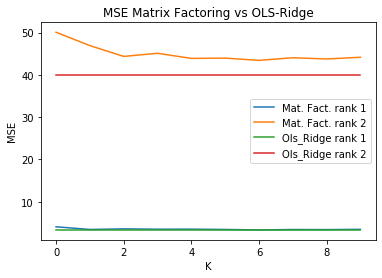

In [68]:
plt.plot(matrix_factfor_10,label='Mat. Fact. rank 1')
plt.plot(matrix_factfor_10_2,label='Mat. Fact. rank 2')
plt.plot(mse_rank1,label='Ols_Ridge rank 1')
plt.plot(mse_rank2,label='Ols_Ridge rank 2')
plt.xlabel('K')
plt.ylabel('MSE')
plt.title('MSE Matrix Factoring vs OLS-Ridge')
plt.legend()